# Exploring the differences between medicinal and non medicinal plants using chemical classes

### Import modules

In [1]:
import os
from ast import literal_eval

import pandas as pd
import numpy as np
from tqdm import tqdm

# Import taxonomy
from utils import get_genus_and_family_info_for_plants, create_np_classifier_vectors, collapse_vector_to_family

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# PCA
from sklearn.decomposition import PCA

# T-SNE
from openTSNE import TSNE

In [2]:
mpl.rcParams['figure.dpi'] = 400
sns.set(context='poster', style='dark')
tqdm.pandas()

Load plant-chemical and plant-disease associations

In [3]:
plant_disease_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=['plant_curie']
)

In [4]:
plant_disease_df.head(1)

,plant_curie
0,ncbitaxon:3369


Medicinal plants

In [5]:
medicinal_plants = plant_disease_df.plant_curie.unique()

Load chemicals

In [6]:
plant_chemical_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [7]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [8]:
len(plant_chemical_df.chemical_curie.unique())

87019

### Annontate medicinal and non-medicinal plants

In [9]:
plant_chemical_df['plant_type'] = plant_chemical_df['plant_curie'].progress_map(
    lambda x: 'Medicinal' if x in medicinal_plants else 'Non-medicinal'
)

100%|██████████| 383591/383591 [01:33<00:00, 4104.86it/s]


In [10]:
plant_chemical_df.head(2)

,plant_curie,chemical_curie,plant_type
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal


### Extract chemical classes

Load NPClassifier classes

In [11]:
np_classifier_dict = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/npclassifier_smiles.tsv.gz',
    sep='\t',
    compression='gzip',
    usecols=[
        'pubchem_openeye_can_smiles',
        'class_results'
    ],
    index_col='pubchem_openeye_can_smiles'
).to_dict()['class_results']

In [12]:
len(np_classifier_dict)

638605

Convert the SMILEs to PubChem ids

In [13]:
smiles_df = pd.read_csv(
    's3://enveda-datascience/daniel_domingo/smiles.tsv.gz',
    sep='\t',
    compression='gzip',
)

In [14]:
pubchem_to_smiles = {}
all_smiles = set()

chemicals_in_plants = set(plant_chemical_df.chemical_curie.unique())

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    if pubchem_id not in chemicals_in_plants:
        continue
    
    all_smiles.add(smiles)
    pubchem_to_smiles[pubchem_id] = smiles

smiles_to_pubchem = {
    smiles: pubchem
    for pubchem, smiles in pubchem_to_smiles.items()
}

100%|██████████| 89270/89270 [00:00<00:00, 318608.50it/s]


In [15]:
# Multiple classes associated with each chemical
np_classifier_dict = {
    smiles_to_pubchem[smile]: literal_eval(classes)
    for smile, classes in np_classifier_dict.items()
    if smile in smiles_to_pubchem and len(literal_eval(classes)) > 0
}
len(np_classifier_dict)

52429

### Compound class annotation

In [16]:
if os.path.exists('../data/np_classifier_annotated_plants.pq'):
    np_classifier_annotated_plants = pd.read_parquet('../data/np_classifier_annotated_plants.pq')
else:
    np_classifier_annotated_plants = plant_chemical_df.copy(deep=True)
    np_classifier_annotated_plants['class'] = np_classifier_annotated_plants['chemical_curie'].map(np_classifier_dict)
    np_classifier_annotated_plants = np_classifier_annotated_plants.explode('class')

    # Drop plants with no annotation
    np_classifier_annotated_plants.dropna(subset=['class'], inplace=True)

    np_classifier_annotated_plants.to_parquet('../data/np_classifier_annotated_plants.pq')

In [17]:
np_classifier_annotated_plants.head(2)

,plant_curie,chemical_curie,plant_type,class
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal,Polyprenylated cyclic polyketides (Hop meroter...
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal,Furocoumarins


### Create plant-class vectors
e.g., plant A: [class1, class2, class3, ...]

In [18]:
if os.path.exists('../data/np_classifier_genus_vector.pq'):
    plant_to_npclassifier_vectors = pd.read_parquet('../data/np_classifier_genus_vector.pq')
else:
    # Time consuming step
    plant_to_npclassifier_vectors = create_np_classifier_vectors(np_classifier_annotated_plants)
    plant_to_npclassifier_vectors.to_parquet('../data/np_classifier_genus_vector.pq')

Generated NP-Classifier vectors: 100%|██████████| 17907/17907 [1:19:13<00:00,  3.77it/s]


In [19]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Fatty acyl CoAs,Sativane sesquiterpenoids,Glycosylmonoacylglycerols,Lupane triterpenoids,m-Terphenyls,Devadarane diterpenoids,"Indole diketopiperazine alkaloids (L-Trp, L-Pro)",Cyclonerane sesquiterpenoids,Fatty acyl glycosides of mono- and disaccharides,...,Simple cyclic polyketides,Pinane monoterpenoids,Clavulones,Sacculatane diterpenoids,Arylnaphthalene and aryltetralin lignans,Branched fatty acids,Furostane steroids,Oplopane sesquiterpenoids,Azo and Azoxy alkaloids,Norkaurane diterpenoids
0,ncbitaxon:1508571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ncbitaxon:409890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
plant_to_npclassifier_vectors.head(2)

,plant_name,Fatty acyl CoAs,Sativane sesquiterpenoids,Glycosylmonoacylglycerols,Lupane triterpenoids,m-Terphenyls,Devadarane diterpenoids,"Indole diketopiperazine alkaloids (L-Trp, L-Pro)",Cyclonerane sesquiterpenoids,Fatty acyl glycosides of mono- and disaccharides,...,Simple cyclic polyketides,Pinane monoterpenoids,Clavulones,Sacculatane diterpenoids,Arylnaphthalene and aryltetralin lignans,Branched fatty acids,Furostane steroids,Oplopane sesquiterpenoids,Azo and Azoxy alkaloids,Norkaurane diterpenoids
0,ncbitaxon:1508571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ncbitaxon:409890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Collapsing plant species to plant families

In [21]:
# Time consuming step
_, family_to_species = get_genus_and_family_info_for_plants(
        set(plant_chemical_df.plant_curie.unique())
    )

order genus: 100%|██████████| 16884/16884 [00:00<00:00, 19474.83it/s]


In [22]:
plant_chemical_df.head(2)

,plant_curie,chemical_curie,plant_type
0,ncbitaxon:1000425,pubchem.compound:3527,Non-medicinal
1,ncbitaxon:1000425,pubchem.compound:68082,Non-medicinal


In [23]:
if os.path.exists('../data/np_classifier_family_vector.pq'):
    np_classifier_family_df = pd.read_parquet('../data/np_classifier_family_vector.pq')
else:
    np_classifier_family_df = collapse_vector_to_family(
        plant_chemical_df, plant_to_npclassifier_vectors, family_to_species
    )
    np_classifier_family_df.fillna(0, inplace=True)
    np_classifier_family_df.to_parquet('../data/np_classifier_family_vector.pq', index=False)

100%|██████████| 513/513 [00:03<00:00, 131.06it/s]


Empty skipped - 24
Medicinal skipped - 247
Non-medicinal skipped - 34


In [24]:
np_classifier_family_df.head(2)

,Fatty acyl CoAs,Sativane sesquiterpenoids,Glycosylmonoacylglycerols,Lupane triterpenoids,m-Terphenyls,Devadarane diterpenoids,"Indole diketopiperazine alkaloids (L-Trp, L-Pro)",Cyclonerane sesquiterpenoids,Fatty acyl glycosides of mono- and disaccharides,Bisnaphthalenes,...,Clavulones,Sacculatane diterpenoids,Arylnaphthalene and aryltetralin lignans,Branched fatty acids,Furostane steroids,Oplopane sesquiterpenoids,Azo and Azoxy alkaloids,Norkaurane diterpenoids,family,ftype
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ncbitaxon:3458,Medicinal
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,ncbitaxon:3458,Non-medicinal


### Converting to percentage

In [25]:
def convert_to_percent(df: pd.DataFrame):
    """Convert counts to percentages for each row."""
    df.set_index(['family', 'ftype'], inplace=True)
    res = df.div(df.sum(axis=1), axis=0)
    
    a = res.sum(axis=1) 
    assert np.isclose(a.values, [1]*a.shape[0]).all(), 'Not all rows sum to 1'
    return res

In [26]:
np_classifier_family_df = convert_to_percent(np_classifier_family_df)
np_classifier_family_df.head(2)

Fatty acyl CoAs  Sativane sesquiterpenoids  \
family         ftype                                                       
ncbitaxon:3458 Medicinal                  0.0                        0.0   
               Non-medicinal              0.0                        0.0   

                              Glycosylmonoacylglycerols  Lupane triterpenoids  \
family         ftype                                                            
ncbitaxon:3458 Medicinal                            0.0                   0.0   
               Non-medicinal                        0.0                   0.0   

                              m-Terphenyls  Devadarane diterpenoids  \
family         ftype                                                  
ncbitaxon:3458 Medicinal               0.0                      0.0   
               Non-medicinal           0.0                      0.0   

                              Indole diketopiperazine alkaloids (L-Trp, L-Pro)  \
family         ftype                                                             
ncbitaxon:3458 Medicinal                                                   0.0   
               Non-medicinal                                               0.0   

                              Cyclonerane sesquiterpenoids  \
family         ftype                                         
ncbitaxon:3458 Medicinal                               0.0   
               Non-medicinal                           0.0   

                              Fatty acyl glycosides of mono- and disaccharides  \
family         ftype                                                             
ncbitaxon:3458 Medicinal                                                   0.0   
               Non-medicinal                                               0.0   

                              Bisnaphthalenes  ...  Simple cyclic polyketides  \
family         ftype                           ...                              
ncbitaxon:3458 Medicinal                  0.0  ...                        0.0   
               Non-medicinal              0.0  ...                        0.0   

                              Pinane monoterpenoids  Clavulones  \
family         ftype                                              
ncbitaxon:3458 Medicinal                        0.0         0.0   
               Non-medicinal                    0.0         0.0   

                              Sacculatane diterpenoids  \
family         ftype                                     
ncbitaxon:3458 Medicinal                           0.0   
               Non-medicinal                       0.0   

                              Arylnaphthalene and aryltetralin lignans  \
family         ftype                                                     
ncbitaxon:3458 Medicinal                                           0.0   
               Non-medicinal                                       0.0   

                              Branched fatty acids  Furostane steroids  \
family         ftype                                                     
ncbitaxon:3458 Medicinal                       0.0                 0.0   
               Non-medicinal                   0.0                 0.0   

                              Oplopane sesquiterpenoids  \
family         ftype                                      
ncbitaxon:3458 Medicinal                            0.0   
               Non-medicinal                        0.0   

                              Azo and Azoxy alkaloids  Norkaurane diterpenoids  
family         ftype                                                            
ncbitaxon:3458 Medicinal                          0.0                      0.0  
               Non-medicinal                      0.0                      0.0  

[2 rows x 566 columns]

In [27]:
if not os.path.exists('../data/npclassifier_family_norm_vector.pq'):
    np_classifier_family_df.to_csv('../data/npclassifier_family_norm_vector.pq', index=True)

# TSNE

In [28]:
def plot(
    x,
    y,
    ax=None,
    title=None,
    draw_legend=True,
    draw_centers=False,
    draw_cluster_labels=False,
    colors=None,
    legend_kwargs=None,
    label_order=None,
    **kwargs
):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = mpl.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Plot mediods
    if draw_centers:
        centers = []
        for yi in classes:
            mask = yi == y
            centers.append(np.median(x[mask, :2], axis=0))
        centers = np.array(centers)

        center_colors = list(map(colors.get, classes))
        ax.scatter(
            centers[:, 0], centers[:, 1], c=center_colors, s=48, alpha=1, edgecolor="k"
        )

        # Draw mediod labels
        if draw_cluster_labels:
            for idx, label in enumerate(classes):
                ax.text(
                    centers[idx, 0],
                    centers[idx, 1] + 2.2,
                    label,
                    fontsize=kwargs.get("fontsize", 6),
                    horizontalalignment="center",
                )

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            mpl.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

In [29]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [30]:
np_classifier_embedding_train = tsne.fit(np_classifier_family_df)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.13 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.5749, 50 iterations in 0.2077 sec
Iteration  100, KL divergence 2.5207, 50 iterations in 0.1470 sec
Iteration  150, KL divergence 2.5155, 50 iterations in 0.1502 sec
Iteration  200, KL divergence 2.4499, 50 iterations in 0.1421 sec
Iteration  250, KL divergence 2.5019, 50 iterations in 0.1851 sec
   --> Time elapsed: 0.83 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...

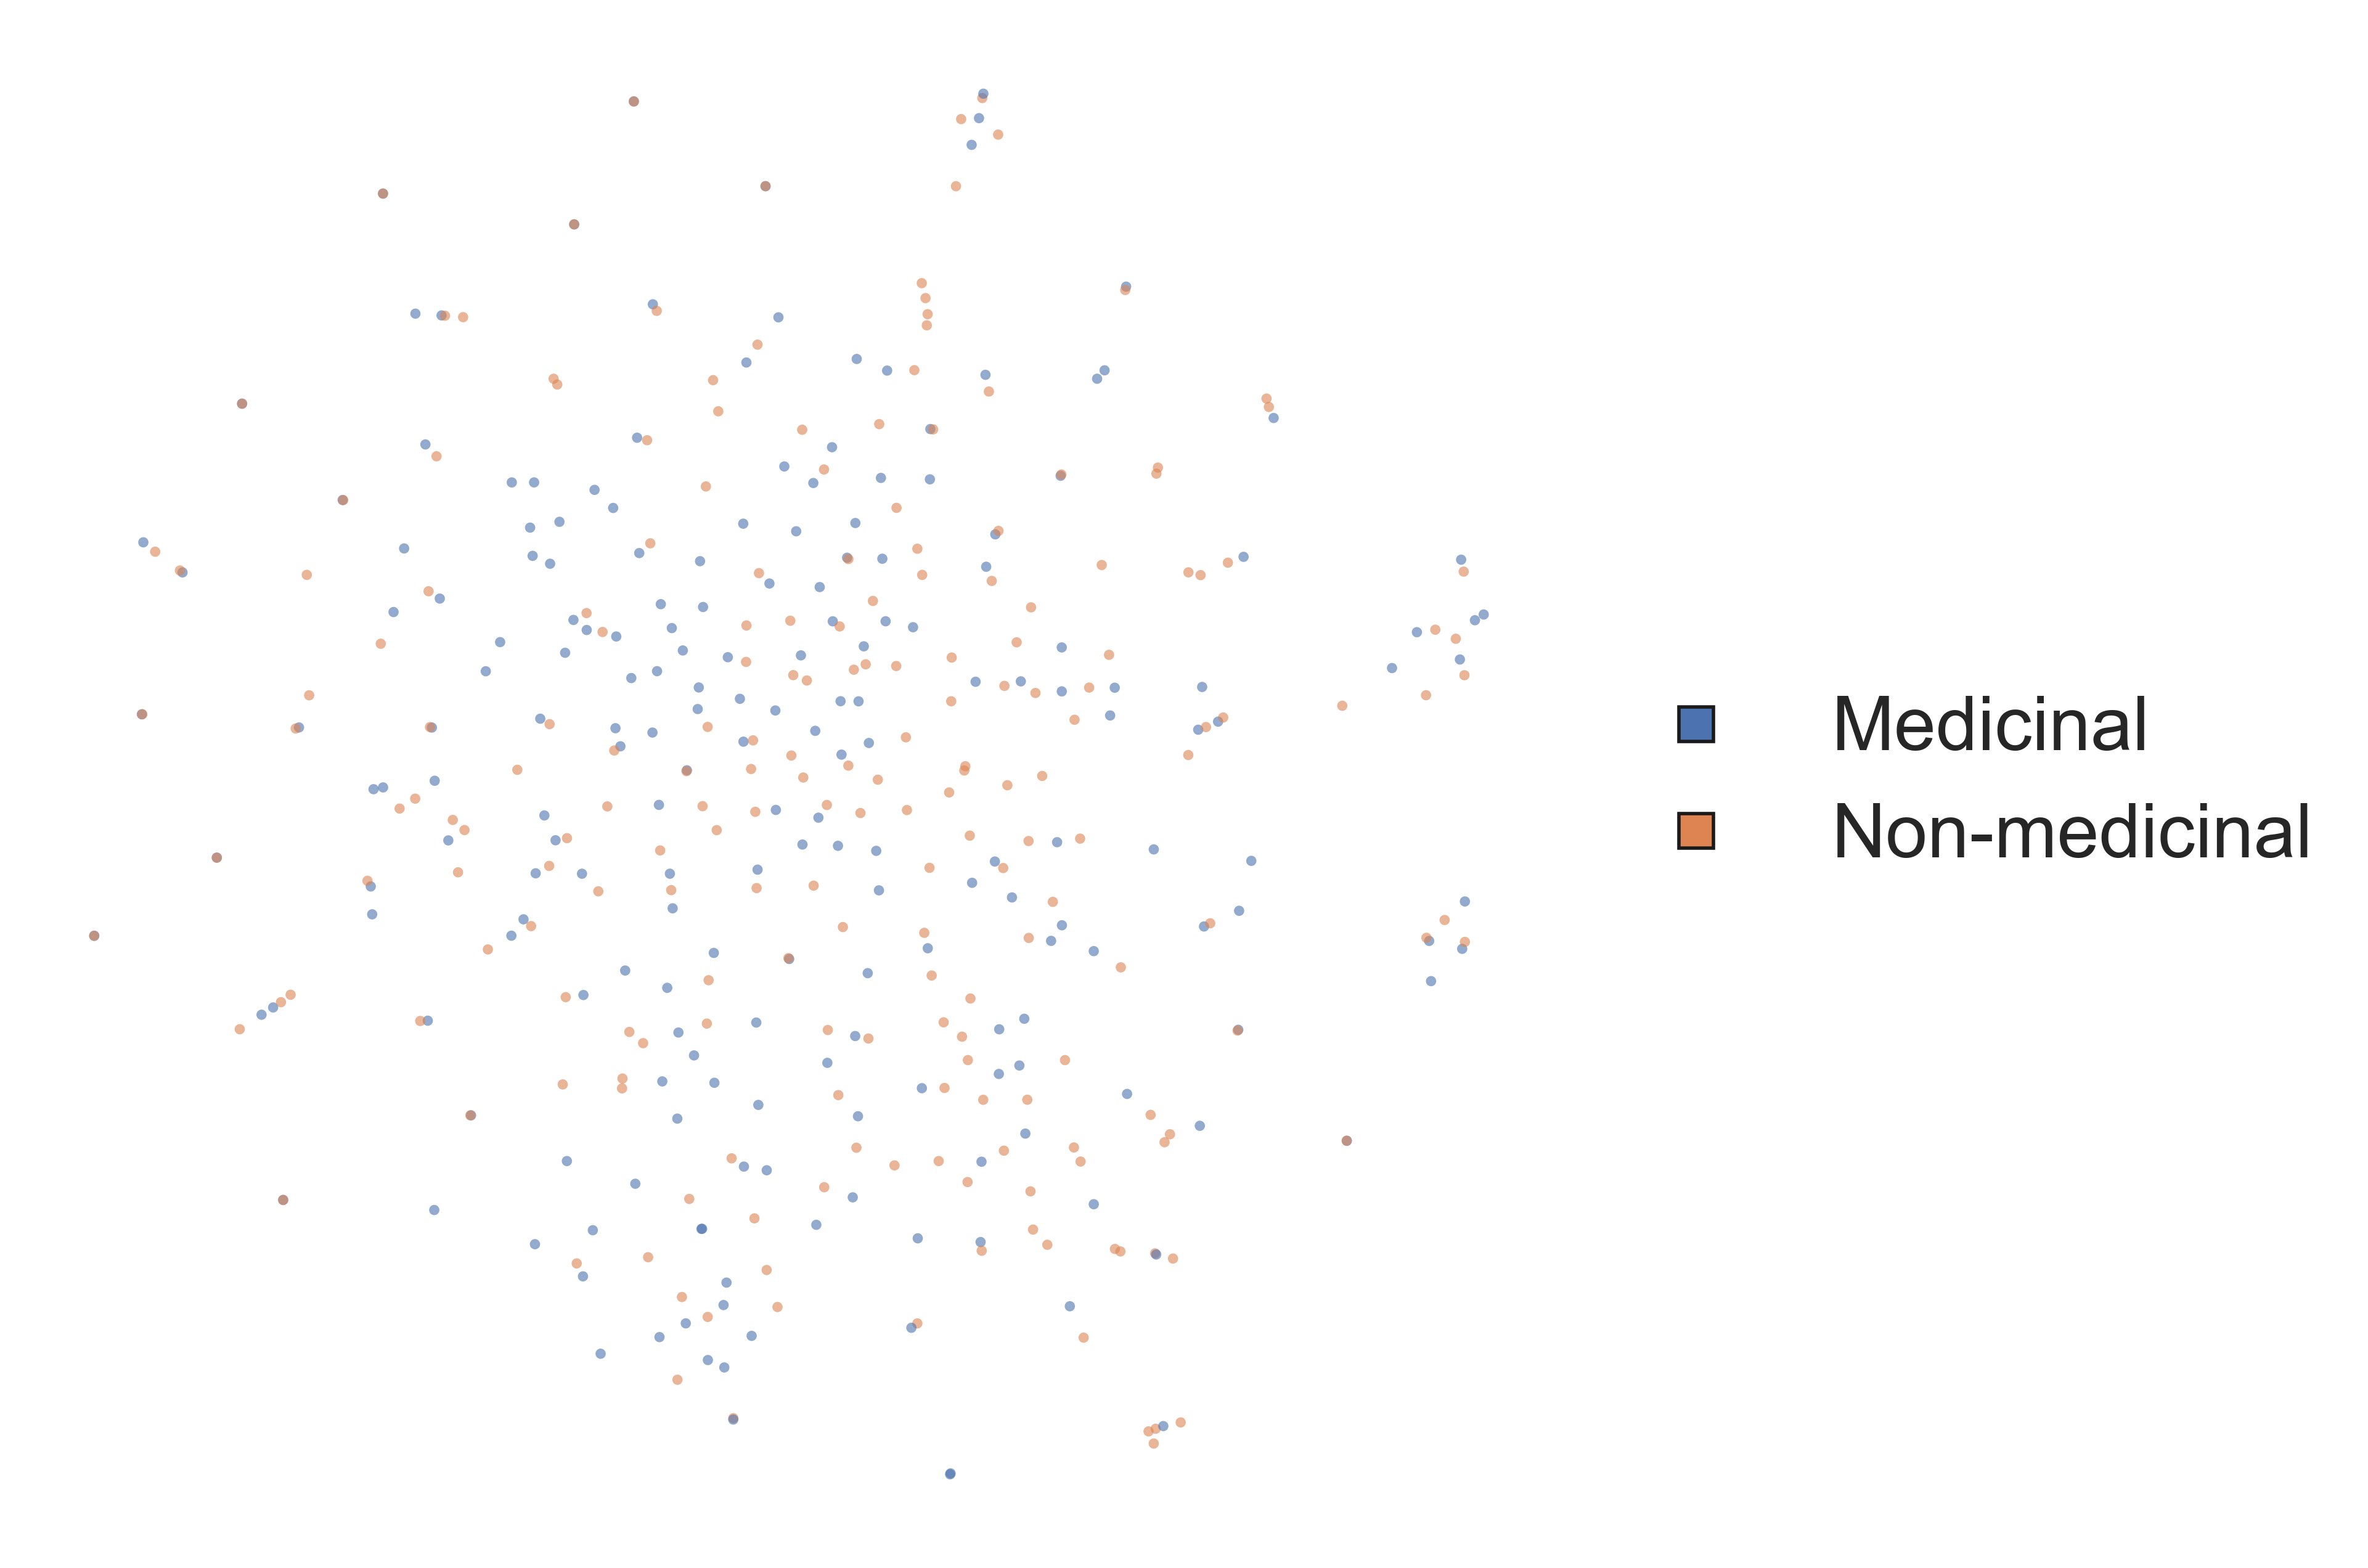

In [31]:
plot(np_classifier_embedding_train, np_classifier_family_df.index.get_level_values('ftype'))

### PCA plot

In [32]:
pca = PCA(n_components=2)

In [33]:
pca_npclassifire = PCA(n_components=2)
npclassifier_components = pca_npclassifire.fit_transform(np_classifier_family_df)

principal_npclassifier_df = pd.DataFrame(
    data = npclassifier_components, 
    columns = ['PC1', 'PC2']
)
principal_npclassifier_df['Type'] = np_classifier_family_df.index.get_level_values('ftype')

In [34]:
pca_npclassifire.explained_variance_ratio_

array([0.12132265, 0.063684  ])

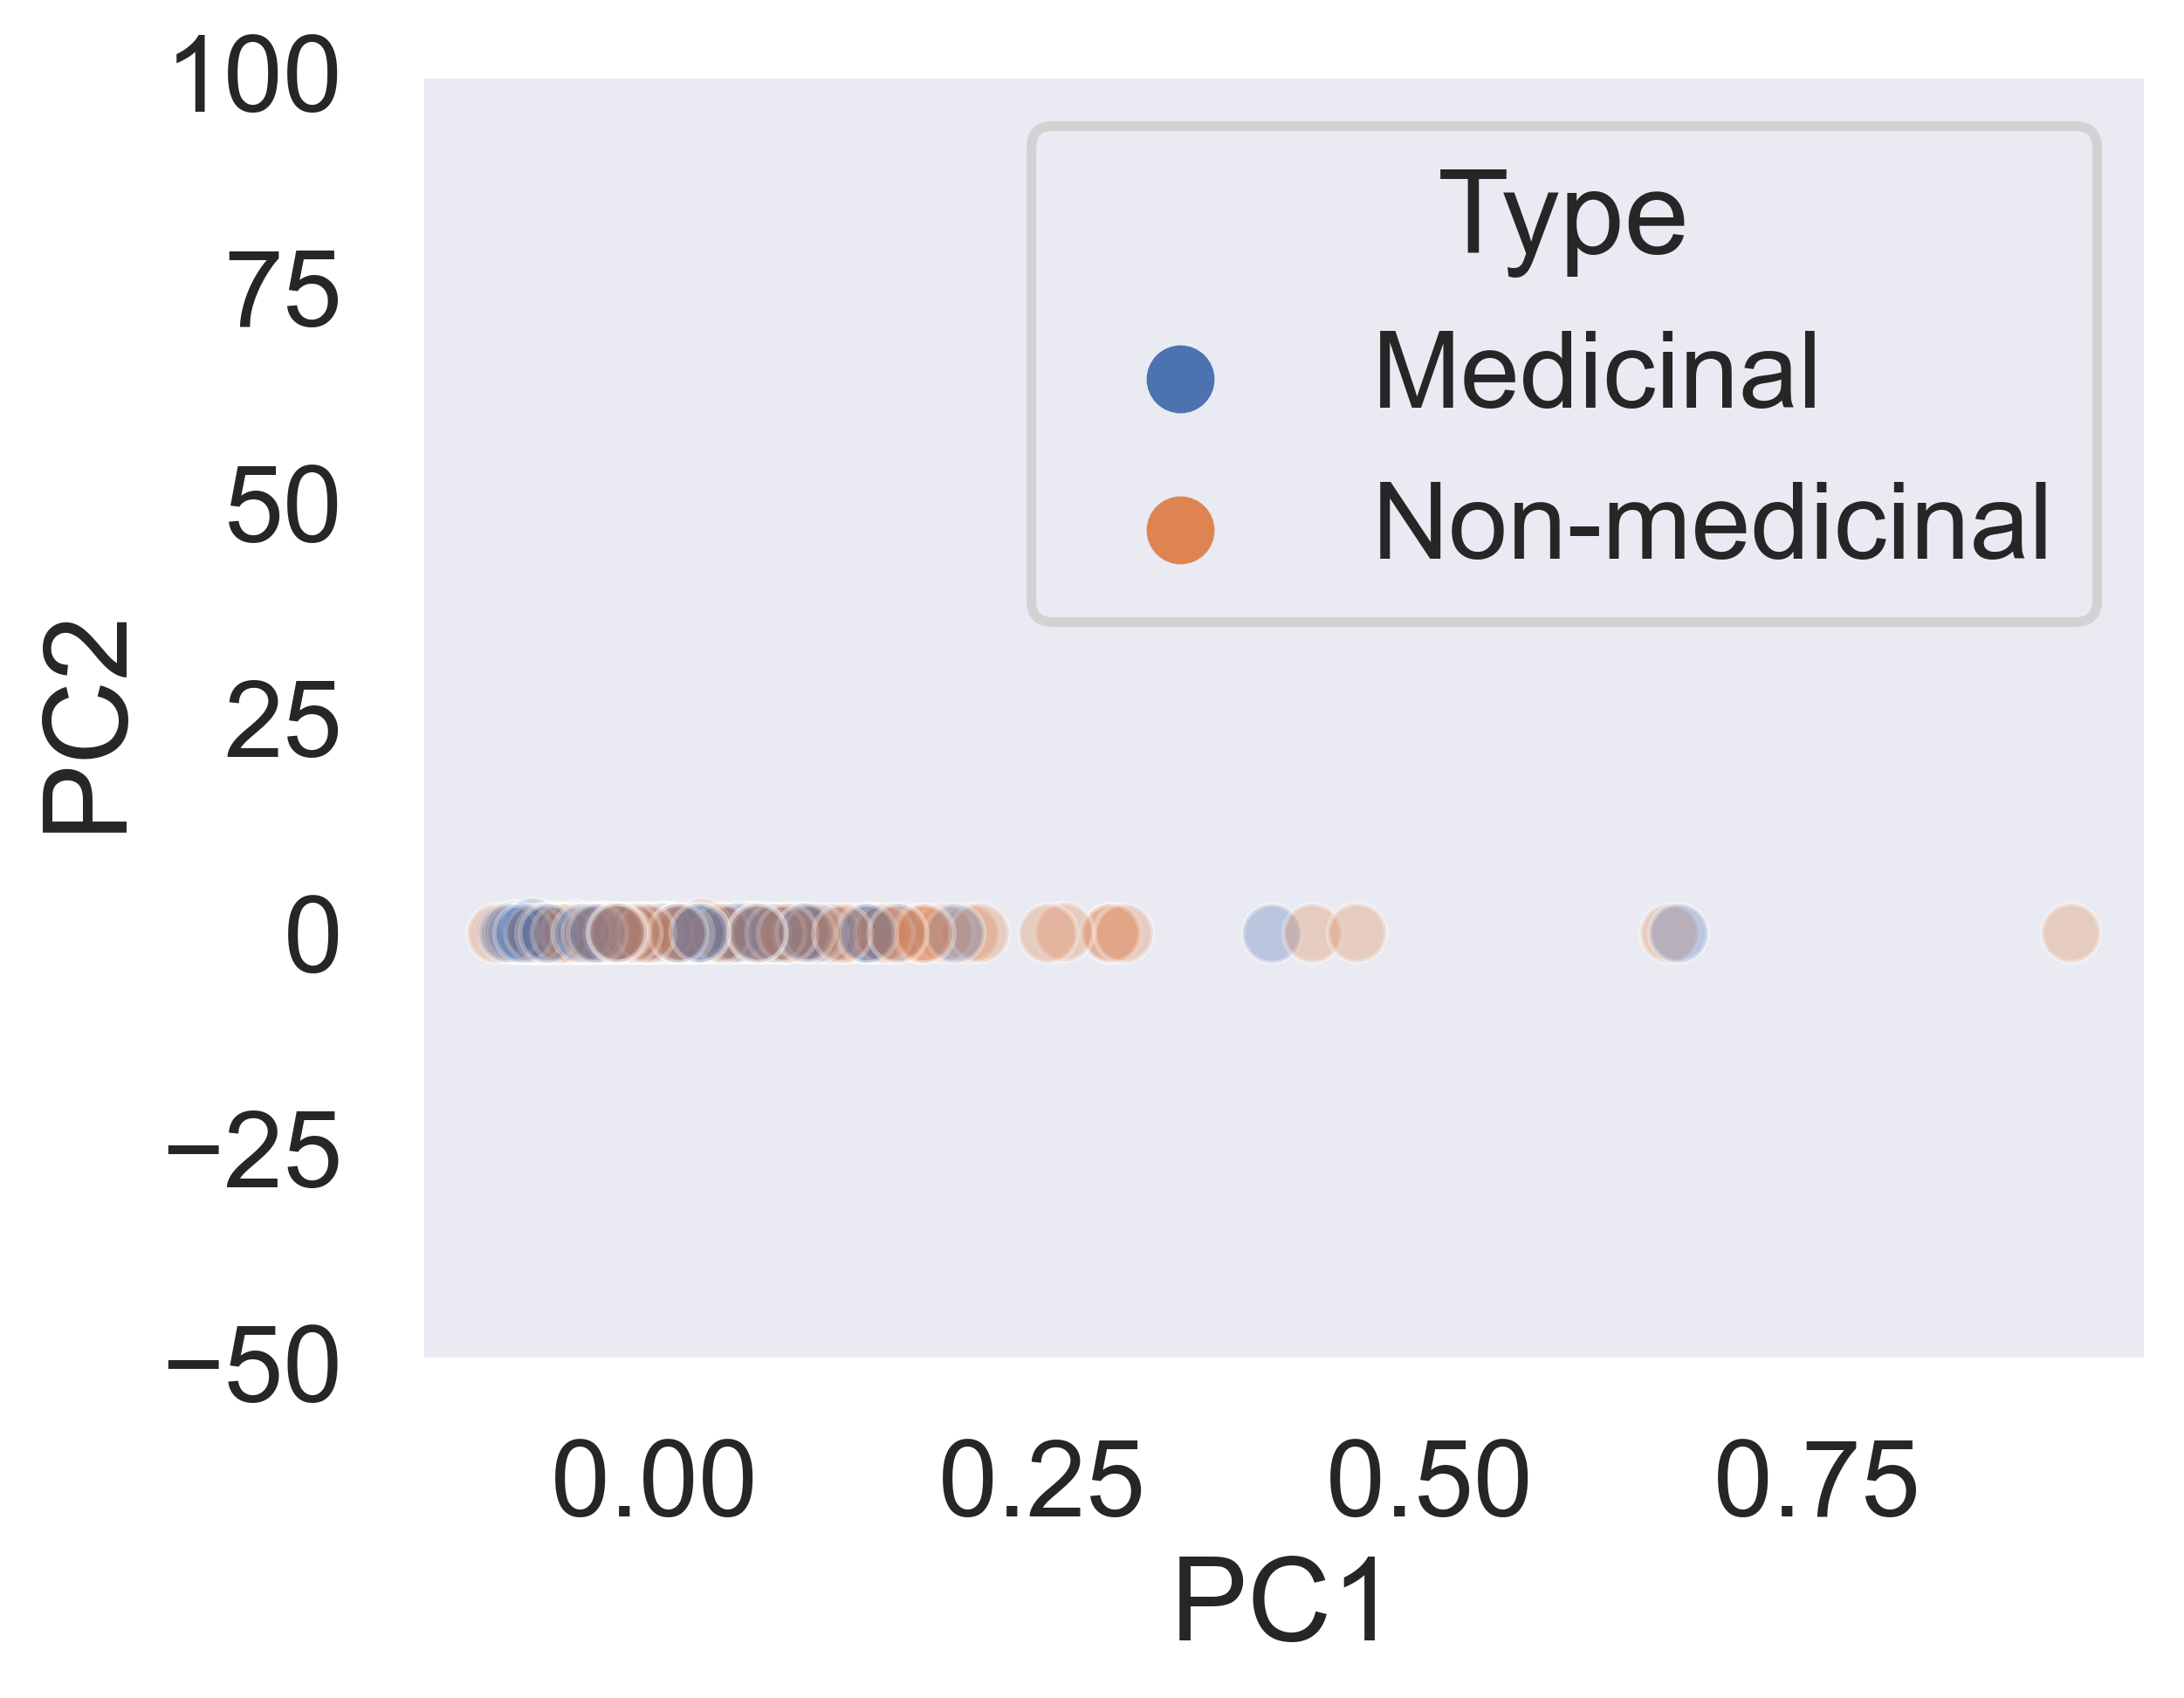

In [35]:
sns.scatterplot(
    data=principal_npclassifier_df,
    x='PC1',
    y='PC2',
    hue='Type',
    alpha=0.3
)
plt.ylim(-50, 100)
plt.show()